# Classification of the breed of chickens using Data Augmentation and Transfer Learning
In this notebook a CNN is created to distinguish between nine different chickens (of different breeds).
First a baseline model is built and then enhanced with Data Augmentation and Transfer Learning.

## Imports
All dependencies needed for the model are loaded here.

In [19]:
%matplotlib inline
import os
import shutil
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from tensorflow.keras import Model
from tensorflow.keras import layers

## Load the training and validation images
The images are in a folder `Chickens` where each of the nine chickens has its own subdirectory.
For further use the images are copied to `/tmp` where each model will load them from.

In [20]:
#from google.colab import drive
#drive.mount('/content/drive')

In [21]:
#DATASET_PATH = '/tmp/chickens'
#BASE_PATH = '/content/drive/MyDrive/Chickens'
BASE_PATH = '/Users/hannes-work/My Drive/Chickens'
DATASET_PATH = '/tmp/Chickens'


blacklisted_files = ['.DS_Store', 'Icon\r']
breeds = os.listdir(BASE_PATH)

# Cleanup existing files to always start with a clean slate
if os.path.exists(DATASET_PATH):
  shutil.rmtree(DATASET_PATH)

os.mkdir(DATASET_PATH)

num_copied_files = 0

for breed in breeds:
    breed_source_path = os.path.join(BASE_PATH, breed)
    breed_target_path = os.path.join(DATASET_PATH, breed)

    if os.path.isdir(breed_source_path):
        os.mkdir(breed_target_path)

        for image in os.listdir(breed_source_path):
            sourcePath = os.path.join(breed_source_path, image)
            targetPath = os.path.join(breed_target_path, image)
            shutil.copy(sourcePath, targetPath)
            num_copied_files += 1

breeds = os.listdir(DATASET_PATH)

# remove .DS_store and other wrong files
for breed in breeds:
    if breed in blacklisted_files:
        path_to_file = os.path.join(DATASET_PATH, breed)
        os.remove(path_to_file)
        print(path_to_file + ' removed')
        num_copied_files -= 1
        continue

    breed_directory = os.path.join(DATASET_PATH, breed)

    if os.path.isdir(breed_directory):
        for filename in os.listdir(breed_directory):
            if filename in blacklisted_files:
                path_to_file = os.path.join(breed_directory, filename)
                os.remove(path_to_file)
                print(path_to_file + ' removed')
                num_copied_files -= 1

breeds = os.listdir(DATASET_PATH)

print(f"Copied {num_copied_files} files")
print(f"We have {len(breeds)} chicken breeds")

/tmp/Chickens/Whiskey/.DS_Store removed
 removedckens/Whiskey/Icon
 removedckens/Pumpkin/Icon
/tmp/Chickens/Lucifer/.DS_Store removed
 removedckens/Lucifer/Icon
/tmp/Chickens/Chick Pea/.DS_Store removed
 removedckens/Chick Pea/Icon
 removedckens/Amaretto/Icon
 removedckens/Popcorn/Icon
 removedckens/Oreo/Icon
 removedckens/Aria/Icon
 removedckens/Espresso/Icon
Copied 854 files
We have 9 chicken breeds


## Explore dataset
Next we explore the dataset a bit by showing a random collection of each chicken.

There are 66 images of Whiskey.


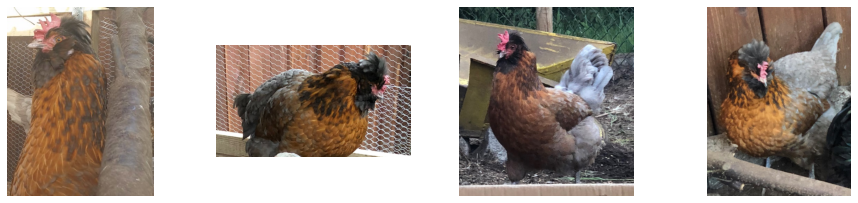

There are 77 images of Pumpkin.


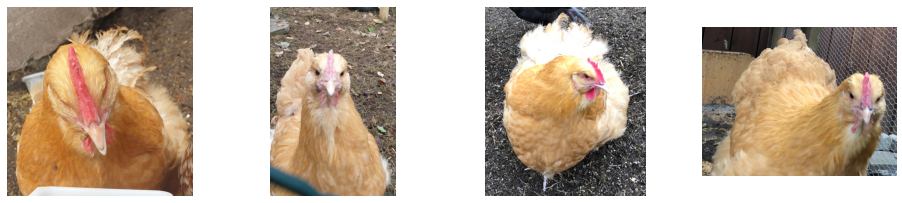

There are 210 images of Lucifer.


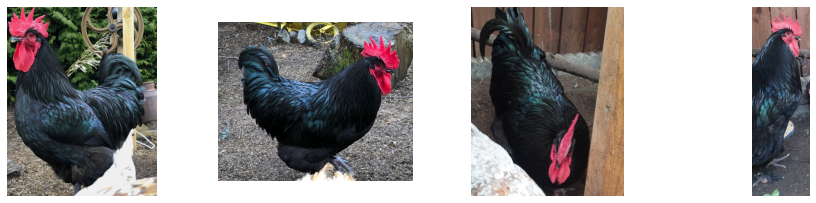

There are 101 images of Chick Pea.


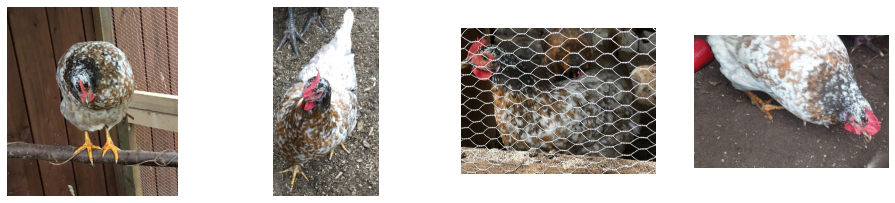

There are 62 images of Amaretto.


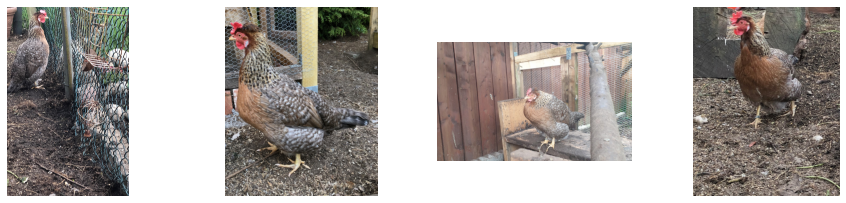

There are 104 images of Popcorn.


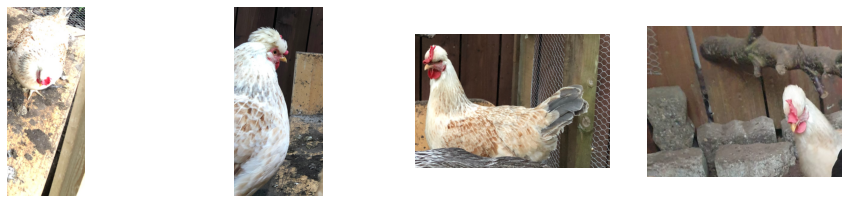

There are 98 images of Oreo.


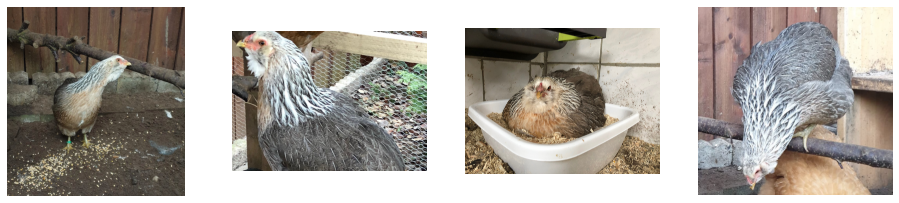

There are 60 images of Aria.


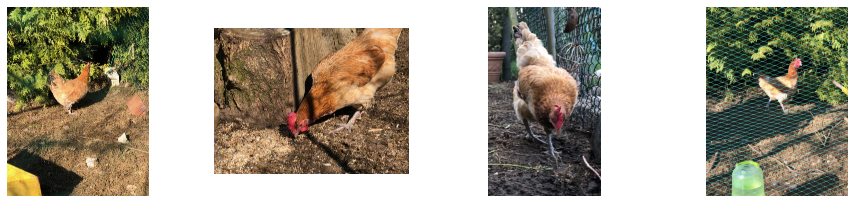

There are 76 images of Espresso.


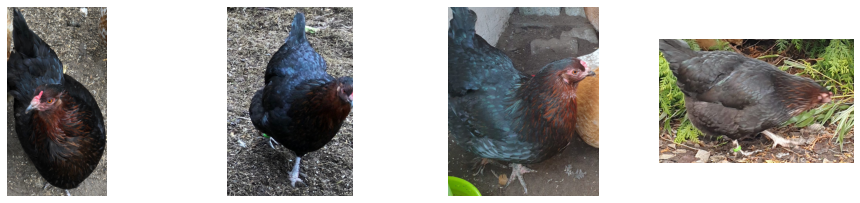

In [22]:
for breed in breeds:
  breed_directory = os.path.join(DATASET_PATH, breed)
  breed_dir_list = os.listdir(breed_directory)

  print(f"There are {len(breed_dir_list)} images of {breed}.")
  
  # show images of dataset
  rows = 4
  cols = 4
  pic_index = 0
  fig = plt.gcf()
  fig.set_size_inches(cols * 4, rows * 4)
  pic_index+=4
  next_pic = [os.path.join(breed_directory, file_name)
              for file_name in breed_dir_list[pic_index - 4:pic_index]
              ]
  for i, img_path in enumerate(next_pic):
    #subplot
    sp = plt.subplot(rows, cols, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

## Global parameters
Here some global parameters are set to be consistent in each model that is built.

In [23]:
BATCH_SIZE = 32
EPOCHS = 10
SEED = 42
IMG_SIZE = 244
SPLIT = 0.3 # 70% training images and 30% validation images

## First Model
As a start we build a very simple model without any Data Augmentation or Transfer Learning.

### Get the training and validation data

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='training',
                                             seed=SEED)
validation_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='validation',
                                             seed=SEED)

Found 601 images belonging to 9 classes.
Found 253 images belonging to 9 classes.


### Create the model

In [25]:
def create_model():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        Dropout(0.3),
        Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPool2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(9, activation='softmax'),
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

model = create_model()

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 240, 32)      18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 238, 238, 16)      4624      
                                                                 
 dropout (Dropout)           (None, 238, 238, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 236, 236, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 118, 16)     0         
 )                                                               
                          

2022-06-10 11:56:41.667092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-10 11:56:41.667391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/10


2022-06-10 11:56:43.136395: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-10 11:56:43.513488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.3749 - accuracy: 0.1564

2022-06-10 11:57:05.258813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 26s 1s/step - loss: 2.3749 - accuracy: 0.1564 - val_loss: 2.1178 - val_accuracy: 0.2490
Epoch 2/10
19/19 [==============================] - 24s 1s/step - loss: 2.0885 - accuracy: 0.2612 - val_loss: 2.1039 - val_accuracy: 0.2490
Epoch 3/10
19/19 [==============================] - 23s 1s/step - loss: 1.9875 - accuracy: 0.2978 - val_loss: 1.9691 - val_accuracy: 0.2767
Epoch 4/10
19/19 [==============================] - 25s 1s/step - loss: 1.8234 - accuracy: 0.3128 - val_loss: 1.8553 - val_accuracy: 0.3281
Epoch 5/10
19/19 [==============================] - 24s 1s/step - loss: 1.7085 - accuracy: 0.3261 - val_loss: 1.7524 - val_accuracy: 0.3597
Epoch 6/10
19/19 [==============================] - 25s 1s/step - loss: 1.6366 - accuracy: 0.3777 - val_loss: 1.7150 - val_accuracy: 0.3478
Epoch 7/10
19/19 [==============================] - 24s 1s/step - loss: 1.5247 - accuracy: 0.4193 - val_loss: 1.7056 - val_accuracy: 0.4111
Epoch 8/10
19/19 [=============

In [27]:
def plot_training_validation_accuracy_loss(history_to_plot):
    acc = history_to_plot.history['accuracy']
    val_acc = history_to_plot.history['val_accuracy']
    loss = history_to_plot.history['loss']
    val_loss = history_to_plot.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

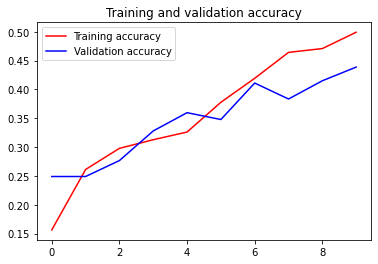

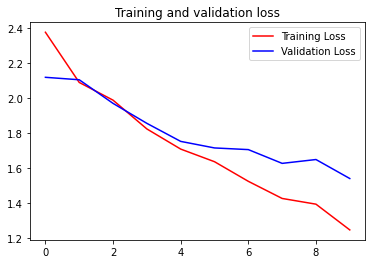

In [28]:
plot_training_validation_accuracy_loss(history)

As we can see the accuracy is not even near a good value.
In the next parts we will try some measures to gain a better accuracy.

## 1. Measure: Data Augmentation

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT,
                                            rotation_range=20,
                                            width_shift_range=0.1,                               
                                            height_shift_range=0.1,
                                            shear_range=0.1,                          
                                            zoom_range=0.1,                          
                                            horizontal_flip=True,
                                            fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            subset='training',
                                            seed=SEED)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)

validation_generator = test_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='validation',
                                             seed=SEED)

Found 601 images belonging to 9 classes.
Found 253 images belonging to 9 classes.


In [30]:
def create_model():
    model = tf.keras.models.Sequential([ 
         
    # First Block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(23, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Third Block
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Fourth Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Fith Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2, 2),
   
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2, 2),   
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(9, activation='softmax')
    ])

  
     # Set training parameters
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])
    
    return model

model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 242, 242, 64)      1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 240, 240, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 120, 120, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 118, 118, 32)      18464     
                                                                 
 conv2d_8 (Conv2D)           (None, 116, 116, 23)      6647      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 58, 23)       0         
 2D)                                                  

In [31]:
history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            verbose=1)

Epoch 1/10


2022-06-10 12:02:41.805576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.1609 - accuracy: 0.2928

2022-06-10 12:03:08.097569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 30s 1s/step - loss: 2.1609 - accuracy: 0.2928 - val_loss: 2.1900 - val_accuracy: 0.3281
Epoch 2/10
19/19 [==============================] - 27s 1s/step - loss: 1.9632 - accuracy: 0.3394 - val_loss: 2.1829 - val_accuracy: 0.2727
Epoch 3/10
19/19 [==============================] - 27s 1s/step - loss: 1.8231 - accuracy: 0.3544 - val_loss: 2.1689 - val_accuracy: 0.2490
Epoch 4/10
19/19 [==============================] - 27s 1s/step - loss: 1.7282 - accuracy: 0.3428 - val_loss: 2.1570 - val_accuracy: 0.2806
Epoch 5/10
19/19 [==============================] - 27s 1s/step - loss: 1.6711 - accuracy: 0.3577 - val_loss: 2.1478 - val_accuracy: 0.2451
Epoch 6/10
19/19 [==============================] - 1087s 60s/step - loss: 1.6033 - accuracy: 0.3727 - val_loss: 2.1344 - val_accuracy: 0.2648
Epoch 7/10
19/19 [==============================] - 92s 5s/step - loss: 1.5546 - accuracy: 0.4193 - val_loss: 2.1093 - val_accuracy: 0.3794
Epoch 8/10
19/19 [==========

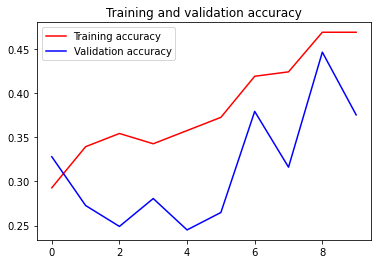

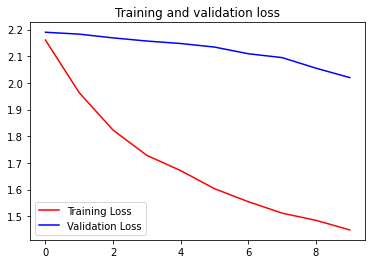

In [32]:
plot_training_validation_accuracy_loss(history)

**2. Measure: VGG19Model**

In [33]:
# Import the VGG-19 model  
from tensorflow.keras.applications.vgg19 import VGG19

vgg19_model = VGG19(input_shape = (IMG_SIZE, IMG_SIZE, 3), 
include_top = False, 
weights = 'imagenet')

In [34]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [35]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [36]:
def create_final_model(vgg19_model):
  
    last_layer = layers.Flatten()(vgg19_model.get_layer('block5_conv4').output)
    last_layer = layers.Dense(64, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.5)(last_layer) 
    last_layer = layers.Dense(32, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.5)(last_layer) 
    last_layer = layers.Dense(128, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.2)(last_layer)      
    last_layer = layers.Dense(9, activation='softmax')(last_layer)         
    
    model = Model(inputs=vgg19_model.input, outputs=last_layer)

    model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model

In [37]:
model = create_final_model(vgg19_model)

In [38]:
history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            verbose=1, 
            )

Epoch 1/10


2022-06-10 12:30:21.006106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.3781 - accuracy: 0.1547

2022-06-10 12:30:46.794988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 34s 2s/step - loss: 2.3781 - accuracy: 0.1547 - val_loss: 2.1927 - val_accuracy: 0.2648
Epoch 2/10
19/19 [==============================] - 33s 2s/step - loss: 2.1964 - accuracy: 0.2180 - val_loss: 2.1938 - val_accuracy: 0.2451
Epoch 3/10
19/19 [==============================] - 31s 2s/step - loss: 2.1891 - accuracy: 0.1947 - val_loss: 2.1924 - val_accuracy: 0.2490
Epoch 4/10
19/19 [==============================] - 32s 2s/step - loss: 2.1929 - accuracy: 0.1814 - val_loss: 2.1763 - val_accuracy: 0.1462
Epoch 5/10
19/19 [==============================] - 32s 2s/step - loss: 2.1771 - accuracy: 0.1897 - val_loss: 2.1407 - val_accuracy: 0.2451
Epoch 6/10
19/19 [==============================] - 32s 2s/step - loss: 2.1690 - accuracy: 0.1847 - val_loss: 2.1428 - val_accuracy: 0.2490
Epoch 7/10
19/19 [==============================] - 31s 2s/step - loss: 2.1557 - accuracy: 0.1664 - val_loss: 2.1239 - val_accuracy: 0.2490
Epoch 8/10
19/19 [=============

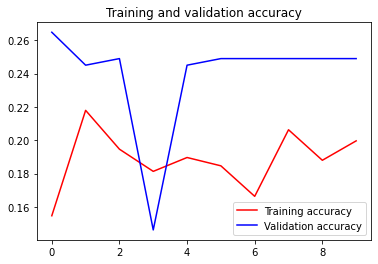

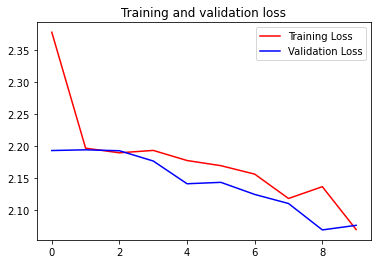

In [39]:
plot_training_validation_accuracy_loss(history)